In [2]:
# Full Startup Failure Analysis with Multiple Classifiers and NLP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
#from wordcloud import WordCloud
import re
import os
from PIL import ImageFont

In [4]:
# Load Data
file_paths = {
    "Finance and Insurance": "/Users/sunidi/Downloads/Startup Failure (Finance and Insurance) (1).csv",
    "Retail Trade": "/Users/sunidi/Downloads/Cleaned_Retail_Startup_Failure.csv",
    "Food and Services": "/Users/sunidi/Downloads/Startup Failure (Food and services) (1).csv",
    "Manufactures": "/Users/sunidi/Downloads/Startup Failure (Manufactures) (1).csv",
    "Information Sector": "/Users/sunidi/Downloads/Startup Failures (Information Sector) (1).csv",
    "Health Sector": "/Users/sunidi/Downloads/Startup Failure (Health Care) (1).csv"
}

valid_dataframes = {}
for key, path in file_paths.items():
    df = pd.read_csv(path, on_bad_lines='warn')
    df["Source_Sector"] = key
    valid_dataframes[key] = df

combined_df = pd.concat(valid_dataframes.values(), ignore_index=True)



In [5]:
# Data Cleaning

def clean_funding(val):
    if isinstance(val, str):
        val = re.sub(r'\([^)]*\)', '', val)
        val = val.upper().replace('$','').replace(',','').strip()
        match = re.search(r'\d+(\.\d+)?', val)
        if not match:
            return np.nan
        num = float(match.group())
        if 'M' in val:
            return num * 1e6
        elif 'B' in val:
            return num * 1e9
        else:
            return num
    return np.nan

combined_df['Funding Amount'] = combined_df['How Much They Raised'].apply(clean_funding)

def extract_years_safe(op_string):
    try:
        if isinstance(op_string, str):
            op_string = re.sub(r'\([^)]*\)', '', op_string)
            parts = re.findall(r'\d{4}', op_string)
            if len(parts) >= 2:
                return int(parts[0]), int(parts[1])
    except:
        pass
    return np.nan, np.nan

combined_df[['Start Year', 'End Year']] = combined_df['Years of Operation'].apply(
    lambda x: pd.Series(extract_years_safe(x))
)

combined_df = combined_df.loc[:, ~combined_df.columns.str.contains('^Unnamed')]
binary_cols = [col for col in combined_df.select_dtypes(include=[np.number]).columns if col != 'Overhype']
combined_df[binary_cols] = combined_df[binary_cols].fillna(0)



In [6]:
# Feature Engineering
model_df = combined_df.dropna(subset=['Overhype'])
model_df['Funding Bucket'] = pd.cut(model_df['Funding Amount'], bins=[-1, 1e6, 1e7, 1e8, 1e9, np.inf], labels=['<1M', '1M-10M', '10M-100M', '100M-1B', '>1B'])
x_numeric_base = ['Start Year', 'End Year'] + [col for col in binary_cols if col in model_df.columns and col not in ['Funding Amount']]
x_numeric = list(dict.fromkeys(x_numeric_base))
x_categorical = ['Funding Bucket']
features = x_categorical + x_numeric
y = (model_df['Overhype'] > 0.5).astype(int)
X = model_df[features]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), x_categorical),
    ('num', StandardScaler(), x_numeric)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)



/var/folders/ng/_9nmb_z90jlfft7cj2nxpq_w0000gp/T/ipykernel_8486/4075619388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['Funding Bucket'] = pd.cut(model_df['Funding Amount'], bins=[-1, 1e6, 1e7, 1e8, 1e9, np.inf], labels=['<1M', '1M-10M', '10M-100M', '100M-1B', '>1B'])


In [7]:
# Classifiers
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True)
}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, preds):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))





Random Forest Accuracy: 0.9375
Confusion Matrix:
 [[45  2]
 [ 1  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        47
           1       0.00      0.00      0.00         1

    accuracy                           0.94        48
   macro avg       0.49      0.48      0.48        48
weighted avg       0.96      0.94      0.95        48


Logistic Regression Accuracy: 0.7500
Confusion Matrix:
 [[35 12]
 [ 0  1]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85        47
           1       0.08      1.00      0.14         1

    accuracy                           0.75        48
   macro avg       0.54      0.87      0.50        48
weighted avg       0.98      0.75      0.84        48


Decision Tree Accuracy: 0.8750
Confusion Matrix:
 [[42  5]
 [ 1  0]]
Classification Report:
               precision    recall  f1-score   support

   

In [8]:
# NLP Analysis on 'Why They Failed'
text_df = combined_df.dropna(subset=['Why They Failed'])
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X_text = tfidf.fit_transform(text_df['Why They Failed'])
keywords = tfidf.get_feature_names_out()
sums = X_text.sum(axis=0).A1
keyword_freq = pd.DataFrame({'keyword': keywords, 'frequency': sums}).sort_values(by='frequency', ascending=False)



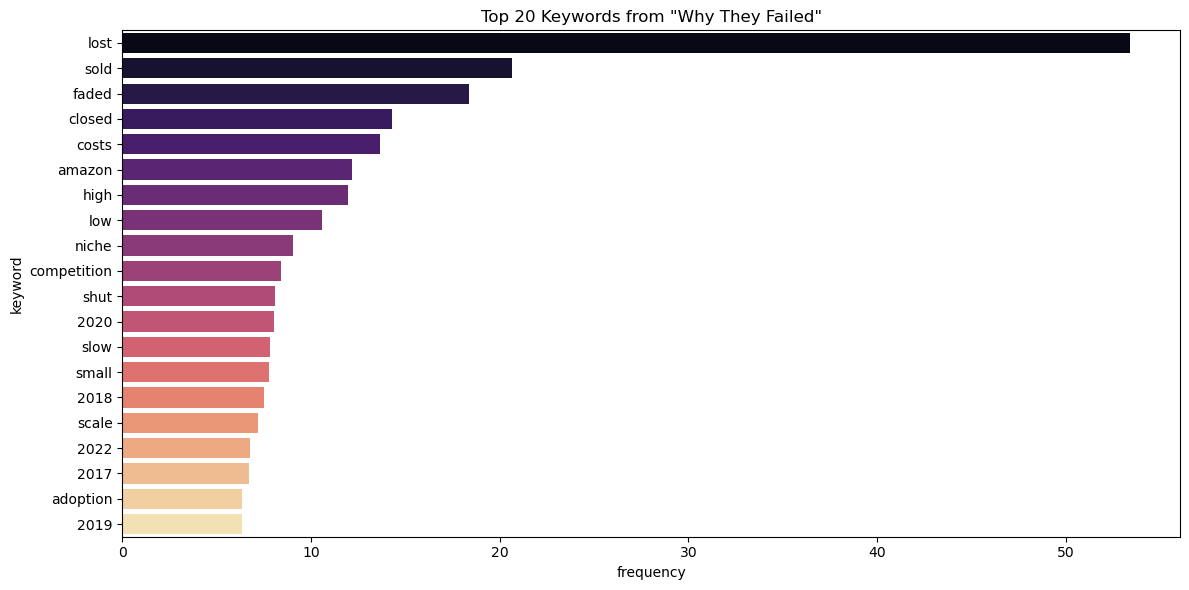

In [9]:
# Plot Top Keywords
plt.figure(figsize=(12,6))
sns.barplot(data=keyword_freq.head(20), x='frequency', y='keyword', palette='magma')
plt.title('Top 20 Keywords from "Why They Failed"')
plt.tight_layout()
plt.show()



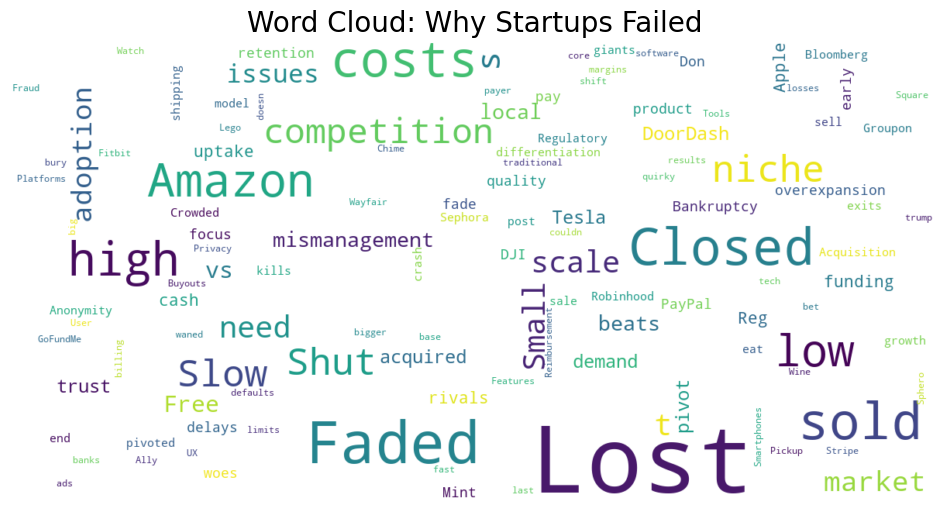

In [10]:
# Word Cloud Fix
# Word Cloud Fix
# Tokenizing for word cloud
wordcloud_df = pd.DataFrame()
wordcloud_df['tokens'] = text_df['Why They Failed'].dropna().astype(str).apply(lambda x: x.split())

def show_wordcloud(data, title=None):
    text = ' '.join([' '.join(tokens) for tokens in data])
    wordcloud = WordCloud(
        background_color='white',
        max_words=300,
        max_font_size=40,
        scale=3,
        random_state=1,
        collocations=False
    ).generate(text)
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

show_wordcloud(wordcloud_df['tokens'], title='Word Cloud: Why Startups Failed')



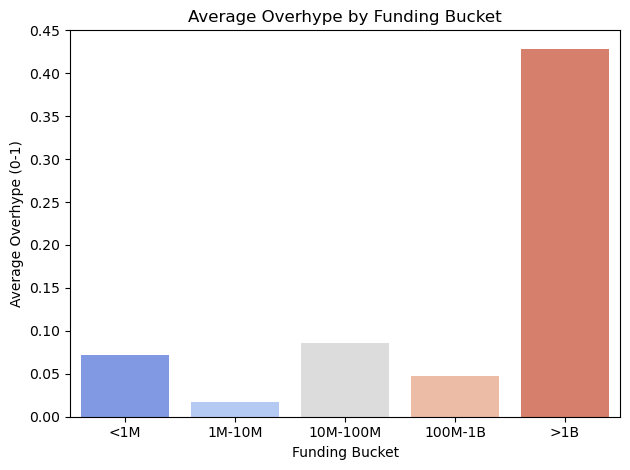

In [11]:
# Plot Funding Bucket vs Overhype
bucket_vs_hype = model_df.groupby('Funding Bucket')['Overhype'].mean().reset_index()
sns.barplot(data=bucket_vs_hype, x='Funding Bucket', y='Overhype', palette='coolwarm')
plt.title('Average Overhype by Funding Bucket')
plt.ylabel('Average Overhype (0-1)')
plt.xlabel('Funding Bucket')
plt.tight_layout()
plt.show()

# Hyperparameter tuning with original model

In [19]:
# Load Data
file_paths = {
    "Finance and Insurance": "/Users/sunidi/Downloads/Startup Failure (Finance and Insurance) (1).csv",
    "Retail Trade": "/Users/sunidi/Downloads/Cleaned_Retail_Startup_Failure.csv",
    "Food and Services": "/Users/sunidi/Downloads/Startup Failure (Food and services) (1).csv",
    "Manufactures": "/Users/sunidi/Downloads/Startup Failure (Manufactures) (1).csv",
    "Information Sector": "/Users/sunidi/Downloads/Startup Failures (Information Sector) (1).csv",
    "Health Sector": "/Users/sunidi/Downloads/Startup Failure (Health Care) (1).csv"
}

valid_dataframes = {}
for key, path in file_paths.items():
    df = pd.read_csv(path, on_bad_lines='warn')
    df["Source_Sector"] = key
    valid_dataframes[key] = df

combined_df = pd.concat(valid_dataframes.values(), ignore_index=True)





In [20]:
# Data Cleaning

def clean_funding(val):
    if isinstance(val, str):
        val = re.sub(r'\([^)]*\)', '', val)
        val = val.upper().replace('$','').replace(',','').strip()
        match = re.search(r'\d+(\.\d+)?', val)
        if not match:
            return np.nan
        num = float(match.group())
        if 'M' in val:
            return num * 1e6
        elif 'B' in val:
            return num * 1e9
        else:
            return num
    return np.nan

combined_df['Funding Amount'] = combined_df['How Much They Raised'].apply(clean_funding)

def extract_years_safe(op_string):
    try:
        if isinstance(op_string, str):
            op_string = re.sub(r'\([^)]*\)', '', op_string)
            parts = re.findall(r'\d{4}', op_string)
            if len(parts) >= 2:
                return int(parts[0]), int(parts[1])
    except:
        pass
    return np.nan, np.nan

combined_df[['Start Year', 'End Year']] = combined_df['Years of Operation'].apply(
    lambda x: pd.Series(extract_years_safe(x))
)

combined_df = combined_df.loc[:, ~combined_df.columns.str.contains('^Unnamed')]
binary_cols = [col for col in combined_df.select_dtypes(include=[np.number]).columns if col != 'Overhype']
combined_df[binary_cols] = combined_df[binary_cols].fillna(0)



In [21]:
# Feature Engineering
model_df = combined_df.dropna(subset=['Overhype'])
model_df['Funding Bucket'] = pd.cut(model_df['Funding Amount'], bins=[-1, 1e6, 1e7, 1e8, 1e9, np.inf], labels=['<1M', '1M-10M', '10M-100M', '100M-1B', '>1B'])
x_numeric_base = ['Start Year', 'End Year'] + [col for col in binary_cols if col in model_df.columns and col not in ['Funding Amount']]
x_numeric = list(dict.fromkeys(x_numeric_base))
x_categorical = ['Funding Bucket']
features = x_categorical + x_numeric
y = (model_df['Overhype'] > 0.5).astype(int)
X = model_df[features]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), x_categorical),
    ('num', StandardScaler(), x_numeric)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)



/var/folders/ng/_9nmb_z90jlfft7cj2nxpq_w0000gp/T/ipykernel_8486/4075619388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['Funding Bucket'] = pd.cut(model_df['Funding Amount'], bins=[-1, 1e6, 1e7, 1e8, 1e9, np.inf], labels=['<1M', '1M-10M', '10M-100M', '100M-1B', '>1B'])


In [22]:
# Classifiers with GridSearchCV and Cross-Validation
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True)
}
from sklearn.model_selection import GridSearchCV, cross_val_score



In [23]:
# Define parameter grids for hyperparameter tuning
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "Support Vector Machine": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

for name, model in models.items():
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)

    print(f"Best Parameters for {name}: {grid.best_params_}")
    print(f"{name} Accuracy: {accuracy_score(y_test, preds):.4f}")
    print("Confusion Matrix:", confusion_matrix(y_test, preds))
    print("Classification Report:", classification_report(y_test, preds))

    # Cross-validation score on balanced training data
    cv_scores = cross_val_score(best_model, X_train_bal, y_train_bal, cv=5, scoring='accuracy')
    print(f"Cross-Validation Accuracy for {name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Running GridSearchCV for Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}
Random Forest Accuracy: 0.9583
Confusion Matrix: [[46  1]
 [ 1  0]]
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.98      0.98        47
           1       0.00      0.00      0.00         1

    accuracy                           0.96        48
   macro avg       0.49      0.49      0.49        48
weighted avg       0.96      0.96      0.96        48

Cross-Validation Accuracy for Random Forest: 0.9629 ± 0.0610
Running GridSearchCV for Logistic Regression...
Best Parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.7500
Confusion Matrix: [[35 12]
 [ 0  1]]
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.74      0.85        47
           1       0.08      1.00      0.14         1

    accuracy          

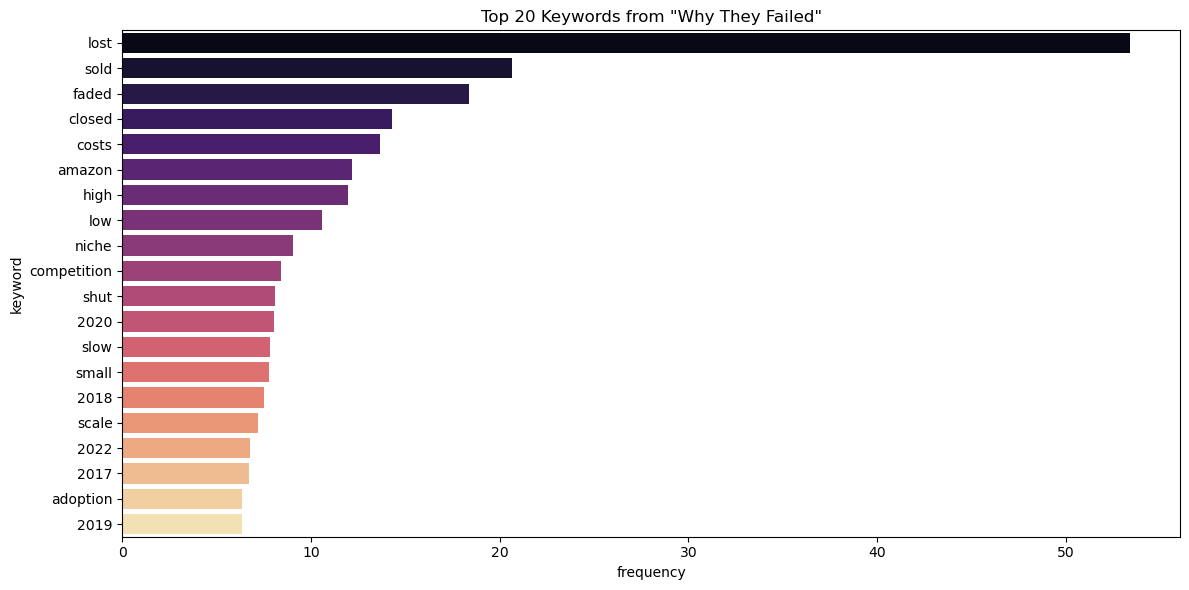

In [24]:
# NLP Analysis on 'Why They Failed'
text_df = combined_df.dropna(subset=['Why They Failed'])
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X_text = tfidf.fit_transform(text_df['Why They Failed'])
keywords = tfidf.get_feature_names_out()
sums = X_text.sum(axis=0).A1
keyword_freq = pd.DataFrame({'keyword': keywords, 'frequency': sums}).sort_values(by='frequency', ascending=False)

# Plot Top Keywords
plt.figure(figsize=(12,6))
sns.barplot(data=keyword_freq.head(20), x='frequency', y='keyword', palette='magma')
plt.title('Top 20 Keywords from "Why They Failed"')
plt.tight_layout()
plt.show()


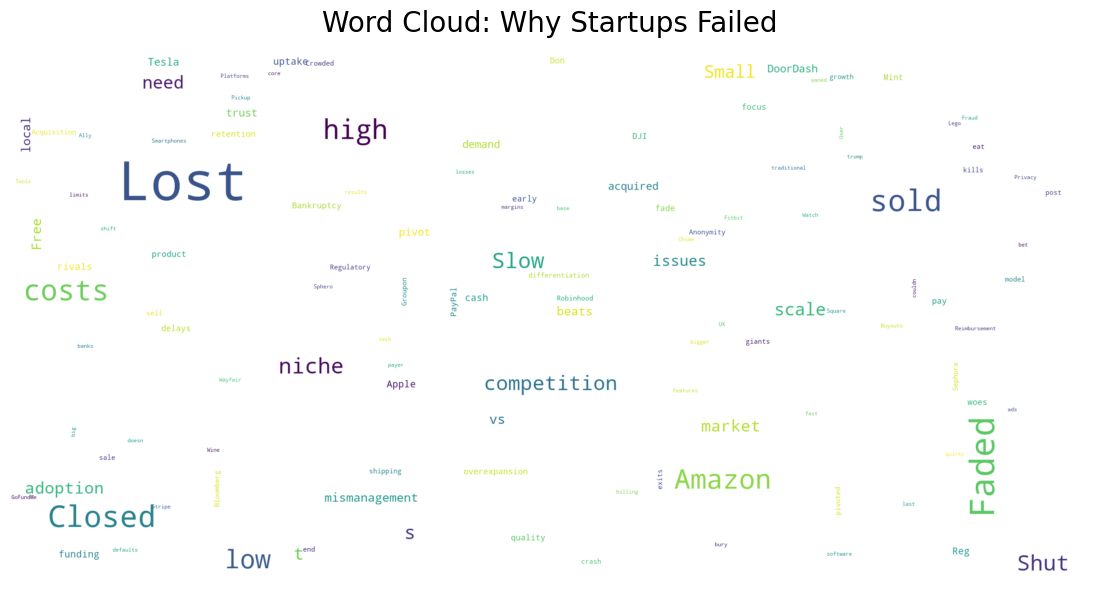

In [25]:
# Word Cloud Fix
# Generate plain text for wordcloud directly from text column
from wordcloud import STOPWORDS
wordcloud_text = ' '.join(text_df['Why They Failed'].dropna().astype(str))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS,
    max_words=300,
    max_font_size=40,
    scale=3,
    collocations=False
).generate(wordcloud_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Why Startups Failed', fontsize=20)
plt.tight_layout()
plt.show()

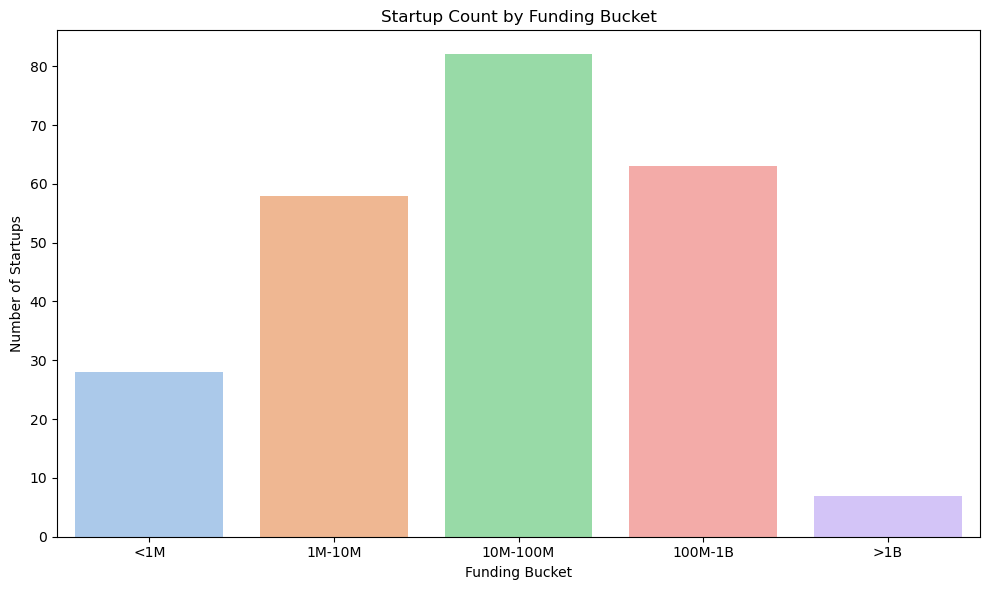

In [29]:
# Plot Funding Bucket vs Overhype

# Additional Visualizations
# 1. Countplot of startups by Funding Bucket
plt.figure(figsize=(10, 6))
sns.countplot(data=model_df, x='Funding Bucket', palette='pastel')
plt.title('Startup Count by Funding Bucket')
plt.xlabel('Funding Bucket')
plt.ylabel('Number of Startups')
plt.tight_layout()
plt.show()



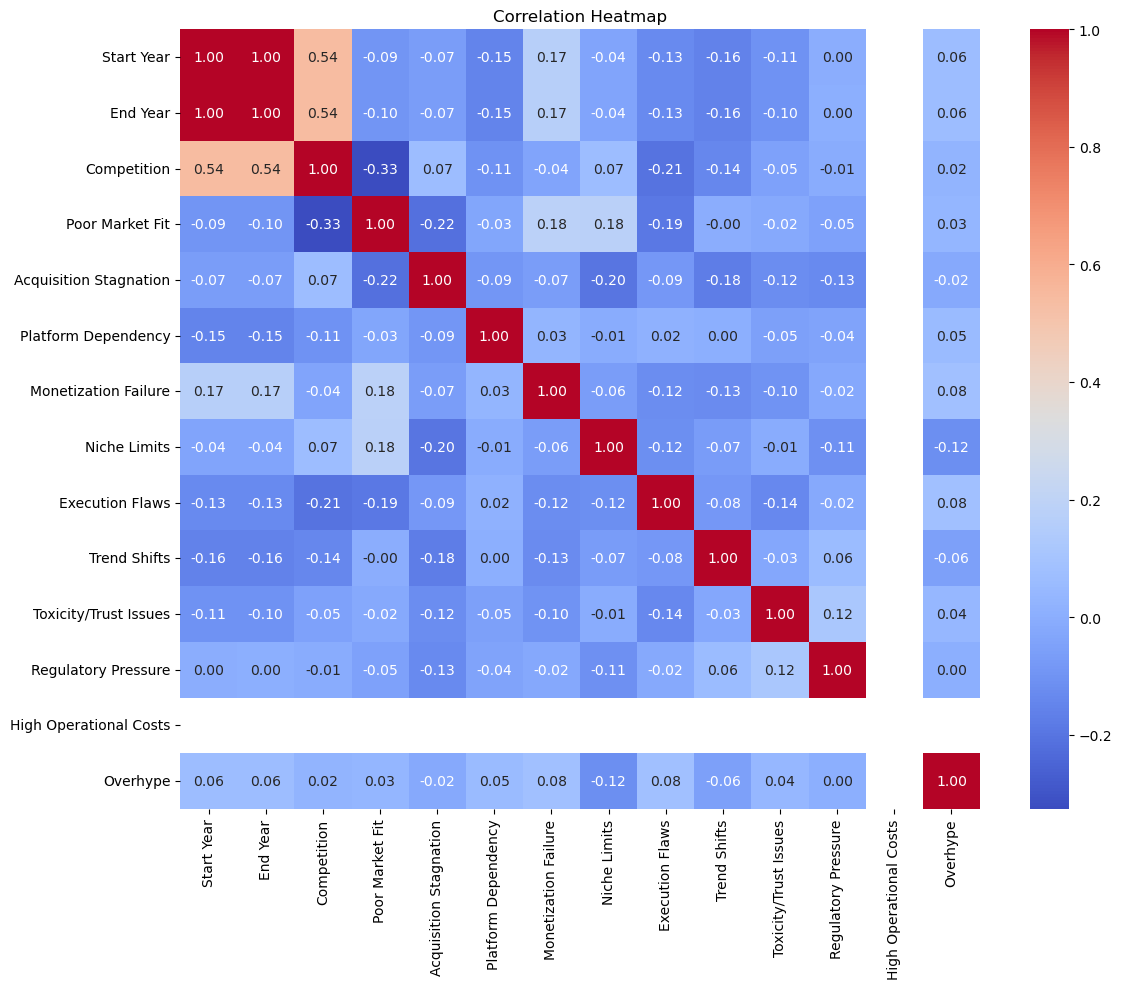

In [30]:
# 2. Heatmap of correlations
plt.figure(figsize=(12, 10))
corr_matrix = model_df[x_numeric + ['Overhype']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()




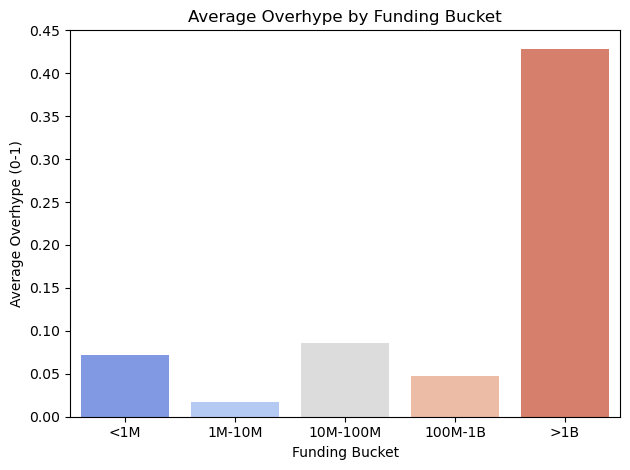

In [31]:
# 3. Violin plot for Funding Amount vs Overhype
bucket_vs_hype = model_df.groupby('Funding Bucket')['Overhype'].mean().reset_index()
sns.barplot(data=bucket_vs_hype, x='Funding Bucket', y='Overhype', palette='coolwarm')
plt.title('Average Overhype by Funding Bucket')
plt.ylabel('Average Overhype (0-1)')
plt.xlabel('Funding Bucket')
plt.tight_layout()
plt.show()

In [ ]:

# Step: Handling Class Imbalance with SMOTE and Evaluating Models

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

# Ensure X_processed and y are already defined in your notebook before this block
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Define weighted classifiers
models = {
    "Random Forest (weighted)": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Logistic Regression (weighted)": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree (weighted)": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    cr = classification_report(y_test, preds)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Confusion Matrix": cm,
        "Classification Report": classification_report(y_test, preds, output_dict=True)
    }

# Summarize performance
summary_df = pd.DataFrame({
    model: {
        "Accuracy": round(metrics["Accuracy"], 3),
        "Recall (Class 1)": round(metrics["Classification Report"].get("1", {}).get("recall", np.nan), 3),
        "Precision (Class 1)": round(metrics["Classification Report"].get("1", {}).get("precision", np.nan), 3)
    }
    for model, metrics in results.items()
}).T

print("\nModel Evaluation Summary:")
print(summary_df)
